# Анализ данных в задаче кредитного скоринга


In [3]:
import numpy as np
import pandas as pd
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
raw_data = pd.read_csv("credit_card_default_analysis.csv")

In [5]:
raw_data.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


Разобьем наш датасет на две подвыборки: первая будет содержать только информацию о заёмщиках, которые вернули кредит (positive), вторая только о тех, кто не вернул (negative).

In [6]:
positive_examples = raw_data[raw_data.default == 0]
negative_examples = raw_data[raw_data.default == 1]

In [7]:
positive_examples.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0


In [8]:
negative_examples.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
13,14,70000,1,2,2,30,1,2,2,0,...,66782,36137,36894,3200,0,3000,3000,1500,0,1
16,17,20000,1,1,2,24,0,0,2,2,...,18338,17905,19104,3200,0,1500,0,1650,0,1
21,22,120000,2,2,1,39,0,0,0,0,...,0,632,316,316,316,0,632,316,0,1


Для избежания дублирования кода определим две функции для отображения графиков. Первая выводит два графика с гистограммами распределения изучаемого признака в двух подвыборках: positive_examples и negative_examples. Вторая рисует график зависимости признака default от изучаемого признака на всем датасете.

In [9]:
def draw_hist_plot(pos, neg, bins=15):
    pylab.figure(figsize=(12,4))

    pylab.subplot(1,2,1)
    pylab.grid()
    pylab.hist(pos, bins=bins, color = 'r')
    pylab.xlabel('Positive')

    pylab.subplot(1,2,2)
    pylab.grid()
    pylab.hist(neg, bins=bins, color = 'b')
    pylab.xlabel('Negative')

    pylab.show()

In [10]:
def draw_feature_to_default_plot(feature):
    pylab.figure(figsize=(15,2))

    pylab.scatter(feature, raw_data['default'])
    pylab.grid()

    pylab.show()

## Размер кредитного лимита

На гистограммах распределений признака LIMIT_BAL заметны значительные отличия. Большая доля невозвращенных кредитов среди тех, размер кредитного лимита которых меньше 100000. В то время как для возвращенных в большей степени характерны значения от 100000 до 300000, чем для невозвращенных. 
По графику зависимости целевого признака от LIMIT_BAL видно, что значения выше 600000 встречаются значительно реже среди невозвращенных кредитов.

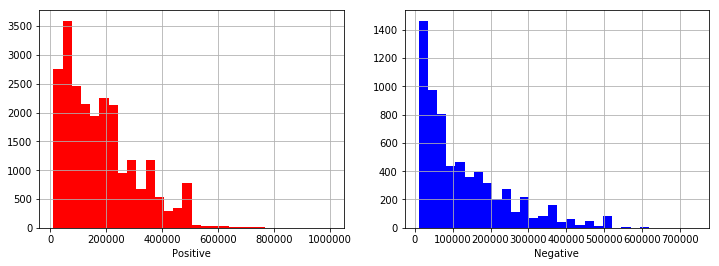

In [11]:
draw_hist_plot(positive_examples['LIMIT_BAL'], negative_examples['LIMIT_BAL'], 30)

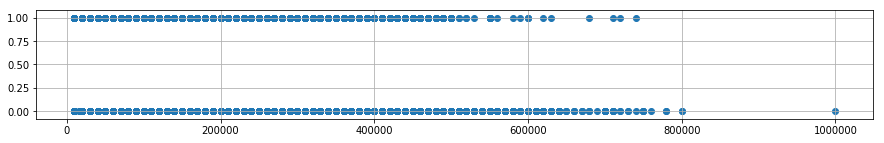

In [12]:
draw_feature_to_default_plot(raw_data['LIMIT_BAL'])

Так как распределение несимметричное и даже отдаленно не напоминает нормальное, использовать параметрические критерии нельзя. В данном случае будем использовать ранговый критерий Манна-Уитни.
Проверяется гипотеза о том, что выборки пришли из одинаковых распределений против двусторонней альтернативы о том, что это не так.

$H_0\colon F_{X_{pos}}(x) = F_{X_{neg}}(x)$

$H_1\colon F_{X_{pos}}(x) = F_{X_{neg}}(x + \Delta), \Delta\neq 0$

In [13]:
stats.mannwhitneyu(positive_examples['LIMIT_BAL'], negative_examples['LIMIT_BAL'])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

На уровне значимости $0.05$ нулевая гипотеза отвергается с очень маленьким значением достигаемого уровня значимости: $6.127742909111652e-190$. Это даёт нам право предполагать, что размер кредитного лимита практически значим в задаче кредитного скоринга.


Так как распределения нашего признака не похожи ни на одно из известных, построим доверительные интервалы для их медиан на основе бутстрепа.

In [14]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [15]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [40]:
np.random.seed(0)

pos_limit_median_scores = map(np.median, get_bootstrap_samples(positive_examples.LIMIT_BAL.values, 1500))
neg_limit_median_scores = map(np.median, get_bootstrap_samples(negative_examples.LIMIT_BAL.values, 1500))

print "95% доверительный интервал для медианы распределения кредитного лимита в положительных примерах:", \
stat_intervals(pos_limit_median_scores, 0.05)
print "95% доверительный интервал для медианы распределения кредитного лимита в отрицательных примерах:", \
stat_intervals(neg_limit_median_scores, 0.05)

95% доверительный интервал для медианы распределения кредитного лимита в положительных примерах: [150000. 150000.]
95% доверительный интервал для медианы распределения кредитного лимита в отрицательных примерах: [80000. 90000.]


Доверительные интервалы для медиан не пересекаются, поэтому мы можем отвергнуть предположение о равенстве медианных значений.

Делая выводы можно сказать, что кредиты с большим значением лимита возвращают чаще. Кредиты со значением лимита меньше 100000 чаще не возвращают. Данный признак в будущем необходимо учитывать при построении модели.

## Пол

По гистограмме распределения делать какие-либо выводы с большой степенью уверенности нельзя. Можно лишь заметить, что доля мужчин в первой подвыборке несколько ниже, но значимо ли это статистически, необходимо проверить.

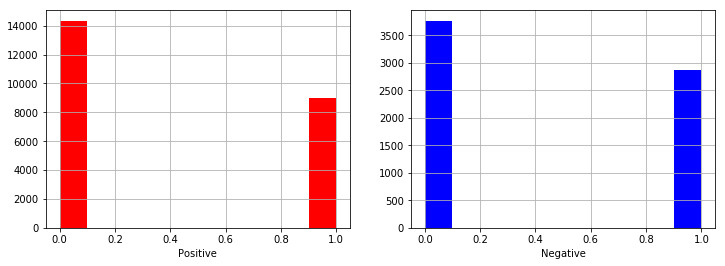

In [41]:
draw_hist_plot(positive_examples['SEX'], negative_examples['SEX'], 10)

Заменим все значения 2 на 0 в изучаемом нами признаке, чтобы впоследствии применить Z-критерий для разности долей в независимых выборках. Будем считать долю мужчин в подвыборках.

In [18]:
positive_examples.SEX[positive_examples.SEX == 2] = 0
negative_examples.SEX[negative_examples.SEX == 2] = 0

C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [20]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [21]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [42]:
print "95%% доверительный интервал для разности долей мужчин в подвыборках: [%f, %f]" %\
      proportions_diff_confint_ind(positive_examples['SEX'], negative_examples['SEX'])

95% доверительный интервал для разности долей мужчин в подвыборках: [-0.060548, -0.033635]


Доверительный интервал не содержит 0, поэтому предположение о равенстве медиан отвергаем.

Проверим гипотезу о равенстве распределений.

$H_0\colon p_1 = p_2$

$H_1\colon p_1 <\neq> p_2$

In [23]:
print "p-value: %e" % proportions_diff_z_test(proportions_diff_z_stat_ind(positive_examples['SEX'], \
                                                                          negative_examples['SEX']))

p-value: 4.472867e-12


На уровне значимости $0.05$ нулевая гипотеза отвергается с достигаемым уровнем значимости $4.472867e-12$

In [43]:
print "Доля мужчин среди вернувших и не вернувших кредит: %f and %f" % \
(float(sum(positive_examples['SEX'])) / len(positive_examples['SEX']), \
 float(sum(negative_examples['SEX'])) / len(negative_examples['SEX']))

Доля мужчин среди вернувших и не вернувших кредит: 0.385850 and 0.432942


Подводя итог можно заметить, что мужчины в целом реже берут кредит, но чаще его не возвращают. Данная разница в долях мужчин среди вернувших и не вернувших кредит статичтически значима, как мы могли убедится. Поэтому пол является практически значимым признаком и должен учитываться при построении модели.

## Образование

По гистограммам распределений можно заметить следующее: докторов наук, не вернувших кредит, нет, чаще всего берут кредит люди получившие степень бакалавра, доля магистров, не вернувших кредит, меньше.

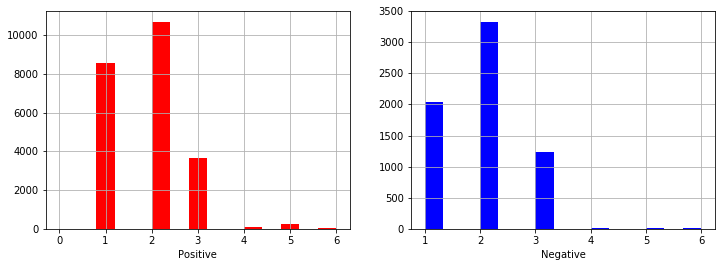

In [25]:
draw_hist_plot(positive_examples['EDUCATION'], negative_examples['EDUCATION'],15)

In [26]:
education_levels = ['phd','master','bachelor','hs_graduate','primary','others','no_info']

Создадим матрицу сопряженности, где будет хранится количество людей со всеми уровнями образования в двух подвыборках.

In [27]:
adjacency_matrix = pd.DataFrame({u'positive': positive_examples.EDUCATION.value_counts(), \
                                 u'negative': negative_examples.EDUCATION.value_counts()})
for i in xrange(0, 7):
    adjacency_matrix.rename(index={i: education_levels[i]}, inplace = True)
    
adjacency_matrix.iloc[0,0] = 0

In [28]:
adjacency_matrix

,negative,positive
phd,0.0,14
master,2036.0,8549
bachelor,3330.0,10700
hs_graduate,1237.0,3680
primary,7.0,116
others,18.0,262
no_info,8.0,43


Так как получившаяся таблица содержит значения-счетчики, для проверки гипотезы о том, что выборки пришли из какого-то распределения будем использовать критерий хи-квадрат.

**гипотеза $H_0$** - рассматриваемая величина имеет распределение Пуассона

In [29]:
print "p-value: ", stats.chi2_contingency(adjacency_matrix, correction=False)[1]

p-value:  1.2332626245415605e-32


Нулевая гипотеза отвергается на уровне значимости $0.05$, достигаемый уровень значимости равен $1.2332626245415605e-32$

Признак образование является статистически значимым в оценке вероятности возврата кредита.

## Семейное положение

На гистограммах видно, что доля женатых/замужних людей среди вернувших кредит несколько ниже, чем среди не вернувших.

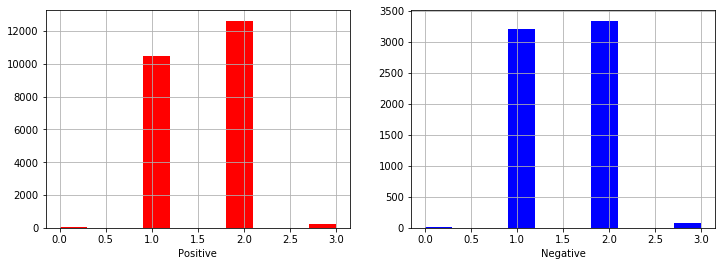

In [30]:
draw_hist_plot(positive_examples['MARRIAGE'], negative_examples['MARRIAGE'],10)

Измерим корреляцию между признаком семейное положение и целевым с помощью коэффицента V Крамера. Он идеально подходит, так как мы работаем с категориальным признаком.

In [31]:
def v_cramer(chi, n, shape):
    return np.sqrt(chi/n/(min(shape[0], shape[1])-1))

In [32]:
marriage_status = ['reject_to_answer', 'married', 'single', 'no_data']

In [33]:
adjacency_matrix_for_marriage = pd.DataFrame({u'positive': positive_examples.MARRIAGE.value_counts(), \
                                 u'negative': negative_examples.MARRIAGE.value_counts()})
for i in xrange(0, 4):
    adjacency_matrix_for_marriage.rename(index={i: marriage_status[i]}, inplace = True)

In [34]:
adjacency_matrix_for_marriage

,negative,positive
single,3341,12623
married,3206,10453
no_data,84,239
reject_to_answer,5,49


In [35]:
print 'v_cramer: ', v_cramer(stats.chi2_contingency(adjacency_matrix_for_marriage, \
                                                    correction=False)[0], len(raw_data), adjacency_matrix_for_marriage.shape)

v_cramer:  0.034478203662766466


Коэффицент V Крамера имеет достаточно маленькое значение, что говорит нам о том, что корреляции между признаками нет. Данный признак не стоит включать в модель.

## Возраст

Гистограммы распределений двух подвыборок имеют сходство. На графике зависимости целевого признака от возраста заметных отличий не наблюдается, есть одиночный выброс в positive_examples.

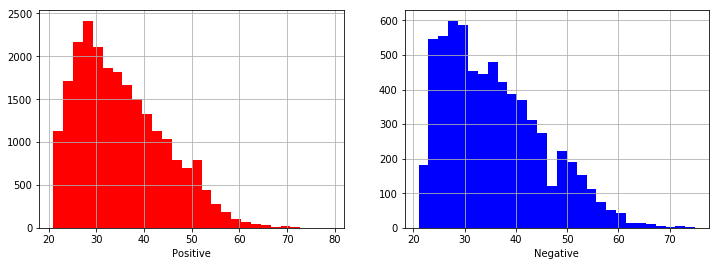

In [46]:
draw_hist_plot(positive_examples['AGE'], negative_examples['AGE'],28)

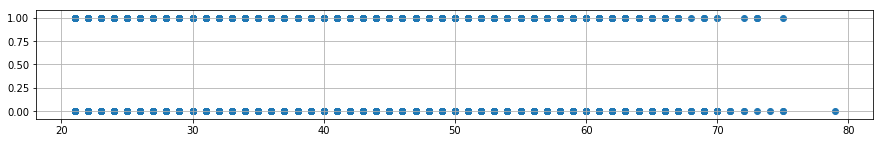

In [37]:
draw_feature_to_default_plot(raw_data['AGE'])

Используем критерий Манна-Уитни, как и в случае первого признака. А также построим доверительный интервал на основе бутстрепа.

$H_0\colon F_{X_{pos}}(x) = F_{X_{neg}}(x)$

$H_1\colon F_{X_{pos}}(x) = F_{X_{neg}}(x + \Delta), \Delta\neq 0$

In [38]:
stats.mannwhitneyu(positive_examples['AGE'], negative_examples['AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

На уровне значимости $0.05$ мы не можем отвергнуть нулевую гипотезу. Достигаемый уровень значимости равен $0.1862517717449308$

In [47]:
np.random.seed(0)

pos_age_median_scores = map(np.median, get_bootstrap_samples(positive_examples.AGE.values, 1500))
neg_age_median_scores = map(np.median, get_bootstrap_samples(negative_examples.AGE.values, 1500))

print "95% доверительный интервал для медианы распределения возраста в положительном примере:",  stat_intervals(pos_age_median_scores, 0.05)
print "95% доверительный интервал для медианы распределения возраста в отрицательном примере:",  stat_intervals(neg_age_median_scores, 0.05)

95% доверительный интервал для медианы распределения возраста в положительном примере: [34. 34.]
95% доверительный интервал для медианы распределения возраста в отрицательном примере: [34. 35.]


Доверительные интервалы для медиан пересекаются (точнее, один интервал принадлежит другому), поэтому предположение о том, что медианы не равны, неверно.

Отличия в распределениях данного признака в подвыборках не являются статистически значимыми, поэтому мы не можем утверждать, что он как-то влияет на целевой признак. Данный признак не стоит использовать в модели. 